### Load Modules

In [684]:
import seaborn as sns
from typing import Union, Literal
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import functools
from anndata import AnnData
import pandas as pd
import scipy

In [695]:
def test(a: None | int = None):
    pass

In [687]:
test(a = 5)

In [ ]:
non_negative_factorization

### Helper Functions

In [700]:
def non_negative_factorization_reimplementation(
        X: np.ndarray, 
        W: np.ndarray | None = None, 
        H: None | np.ndarray=None, 
        n_components: Union[None, int]=None, 
        init: Literal["custom"] | None=None,
        update_H: bool=True,
        max_iter: int=200
) -> tuple[np.ndarray, np.ndarray, int]:

    if n_components is None:
        if H is not None:
            n_components = H.shape[0]
        else:
            n_components = min(X.shape)
    if W is None and init != "custom":
        W = np.ones((X.shape[0], n_components))
    if H is None and init != "custom":
        H = np.ones((n_components, X.shape[1]))
    
    for _ in tqdm(range(max_iter)):
        W = (W.T * (H @ X.T) / (H @ H.T @ W.T + 1e-9)).T
        if update_H:
            H = (H * (W.T @ X) / (W.T @ W @ H + 1e-9))
    return W, H, max_iter

def cosine_similarity_rows(A: np.array, B: np.array) -> np.array:
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def nmf_transfer_basic(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference.X.toarray(), n_components=n_components)
    # NMF run 2
    W, H, _ = nmf_func(adata_query[:, shared_genes].X.toarray(), H=H_init[:, shared_genes_mask_reference], update_H=False)
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "W": W,
        "H": H,
    }

def nmf_transfer_masked(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference[:, shared_genes_mask_reference].X.toarray().copy(), n_components=n_components)
    V = functools.reduce(lambda a, b: np.hstack([a,b]),[(nmf_func(adata_query[:, shared_genes].X.toarray().copy()[:, gene_mask], H=H_init[:, gene_mask], update_H=False))[0] @ H_init[:, ~gene_mask] for gene_mask in ~np.eye(len(shared_genes), dtype=bool)])
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "V": V,
    }


def benchmark_reconstruction(count_matrix: np.array, count_matrix_reconstructed: np.array) -> None:
    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

sparse_to_numpy = lambda func: lambda *args, **kwargs: func(
    *[arg.toarray() if scipy.sparse.issparse(arg) else arg for arg in args],
    **{k: v.toarray() if scipy.sparse.issparse(v) else v for k, v in kwargs.items()}
)

benchmark_reconstruction = sparse_to_numpy(benchmark_reconstruction)

In [295]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Load Data

celltypes = 
{'BZE',
 'Blood vasc.',
 'Cycling/GC B cell',
 'Glial',
 'Goblet',
 'Lymphatic',
 'MZE',
 'Macrophage',
 'NM',
 'Paneth',
 'Plasma',
 'Rest B',
 'Stem/TA',
 'Stroma',
 'T cell',
 'TZE',
 'Tuft',
 'cDC/monocyte',
 'neurons/enteroendocrine',
 'pDC'}

In [296]:
celltype = "Stem/TA"
adata_sp = (lambda x: x[x.obs["nico_ct"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
#adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = (lambda x: x[x.obs["cluster"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad"))
#adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
#sc.pp.filter_genes(adata_sp, min_counts=50)
#sc.pp.filter_genes(adata_sc, min_counts=50)
sc.pp.filter_genes(adata_sp, min_counts=1)
sc.pp.filter_genes(adata_sc, min_counts=1)
shared_genes_mask_sc = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes_mask_sp = np.isin(adata_sp.var_names, adata_sc.var_names)
shared_genes = adata_sc[:, shared_genes_mask_sc].var_names
print(f"{len(shared_genes)=}")

len(shared_genes)=138


In [297]:
n_components = 20

res_sklearn = nmf_transfer_basic(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components,
    nmf_func=non_negative_factorization
)

res_reimplementation = nmf_transfer_basic(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components,
    nmf_func=functools.partial(non_negative_factorization_reimplementation, max_iter=500)
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 500/500 [00:00<00:00, 9025.75it/s]


## NMF

### Baseline Reconstruction Quality of Spatial Data

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


n_components=20
Baseline reconstruction spatial data using sklearns NMF implementation


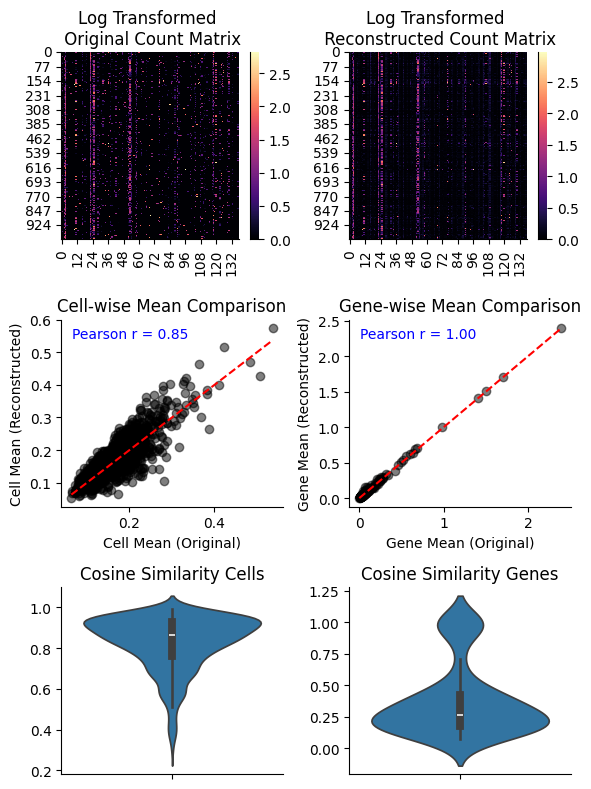

Baseline Reconstruction spatial data using manual implementation of NMF


100%|██████████| 500/500 [00:00<00:00, 3123.83it/s]


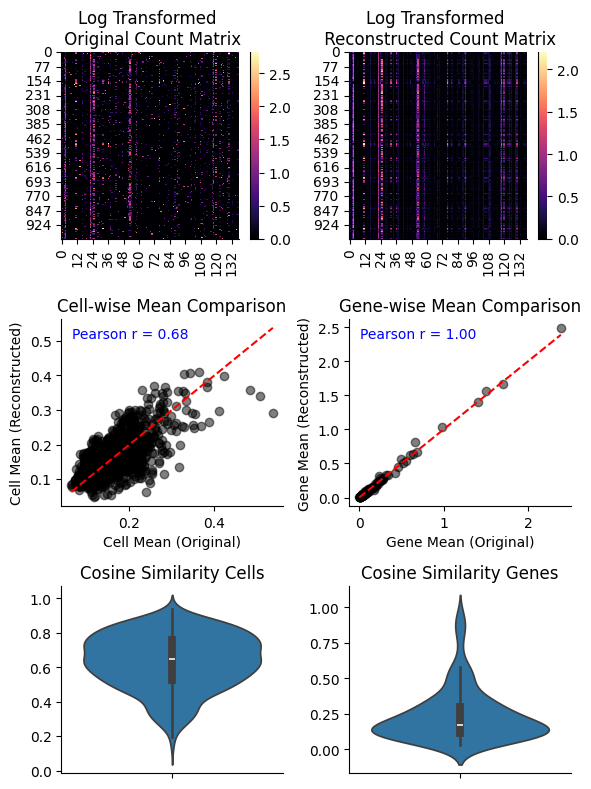

In [298]:
print(f"{n_components=}")
print("Baseline reconstruction spatial data using sklearns NMF implementation")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    functools.partial(non_negative_factorization, n_components=n_components)
)
print("Baseline Reconstruction spatial data using manual implementation of NMF")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    functools.partial(non_negative_factorization_reimplementation, n_components=n_components, max_iter=500)
)

### Reconstruction Quality of single cell reference data

n_components=20
Baseline reconstruction single cell data using sklearns NMF implementation


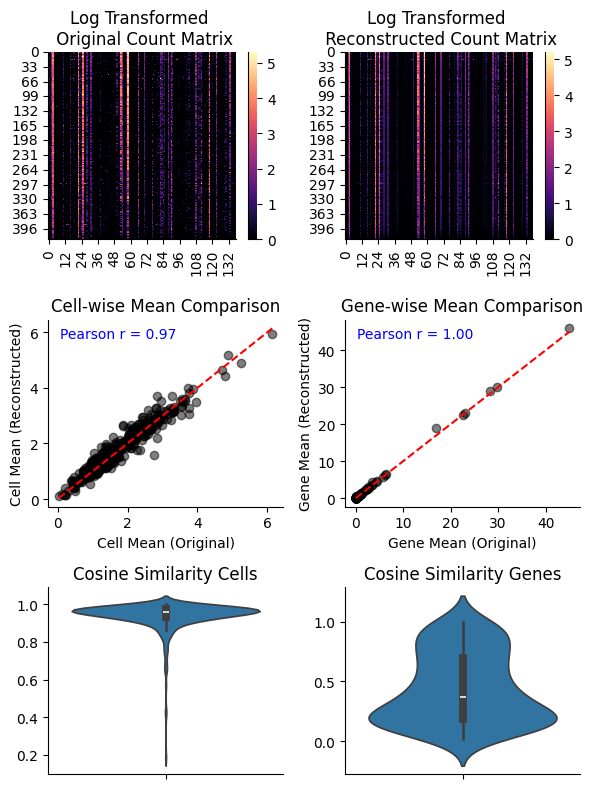

Baseline Reconstruction single cell data using manual implementation of NMF


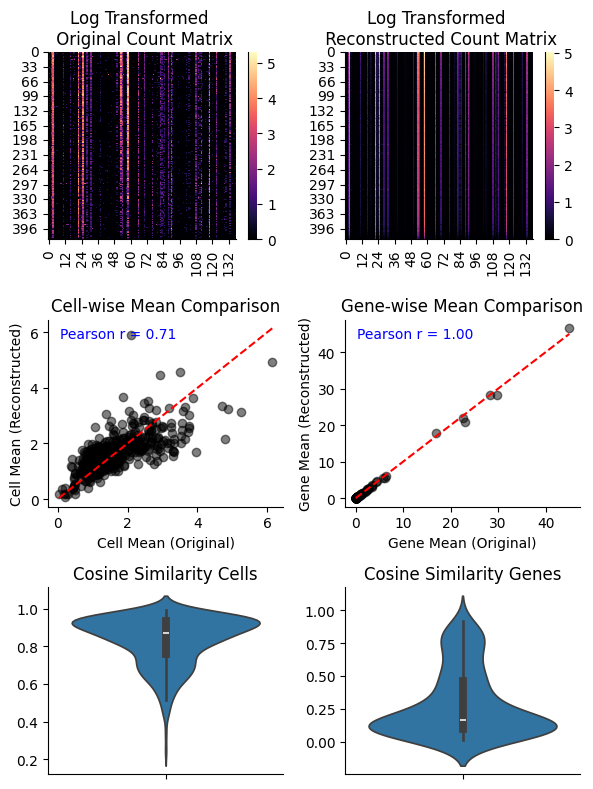

In [299]:
print(f"{n_components=}")
print("Baseline reconstruction single cell data using sklearns NMF implementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_reference_array"][:, res_dict["shared_genes_mask_reference"]],
     res_dict["W_init"] @ res_dict["H_init"][:, res_dict["shared_genes_mask_reference"]]
 ))(
     res_sklearn
 )

print("Baseline Reconstruction single cell data using manual implementation of NMF")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_reference_array"][:, res_dict["shared_genes_mask_reference"]],
     res_dict["W_init"] @ res_dict["H_init"][:, res_dict["shared_genes_mask_reference"]]
 ))(
     res_reimplementation
 )

### Reconstruction Quality of spatial data with H-Matrix (gene by factor matrix) initialized and fixed from previous single cell NMF

n_components=20
Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run sklearn implementation


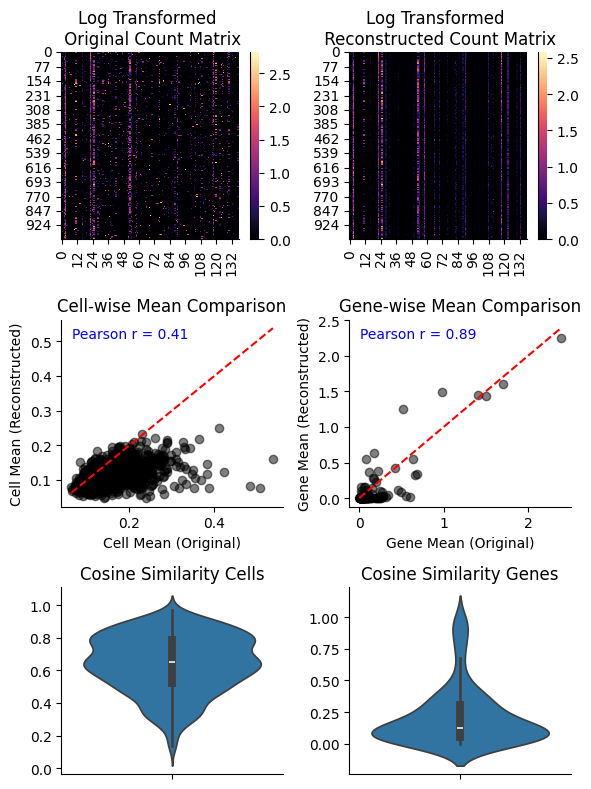

Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation


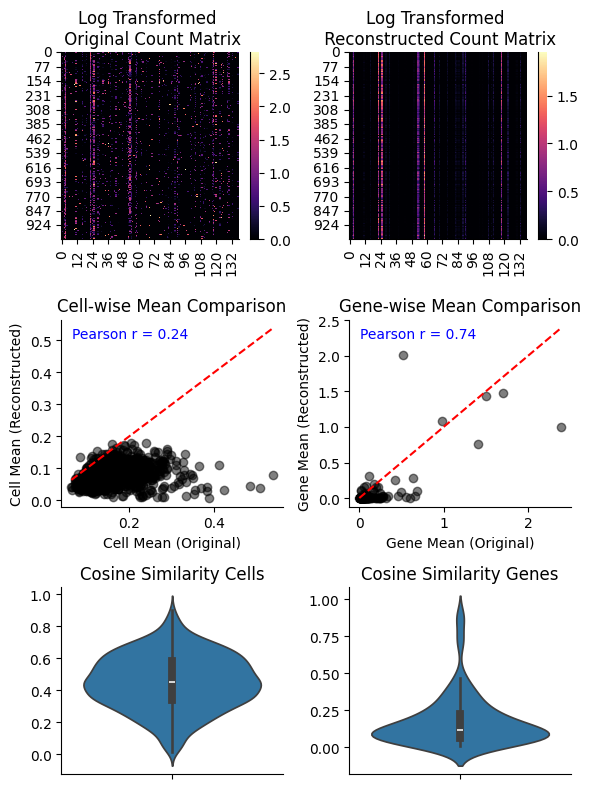

In [300]:
print(f"{n_components=}")
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run sklearn implementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_query_array"],
     res_dict["W"] @ res_dict["H"]
 ))(
     res_sklearn
 )
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_query_array"],
     res_dict["W"] @ res_dict["H"]
 ))(
     res_reimplementation
 )

### Reconstruction Quality of spatial data iteratively with individual masked genes with H-Matrix (gene by factor matrix) initialized and fixed from previous single cell NMF 

In [301]:
res_masked_1 = nmf_transfer_masked(
    adata_sp, adata_sc, n_components=n_components, nmf_func=non_negative_factorization
)

res_masked_2 = nmf_transfer_masked(
    adata_sp, adata_sc, n_components=n_components, nmf_func=non_negative_factorization_reimplementation
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

n_components=20
Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using sklearn nmf and masked genes


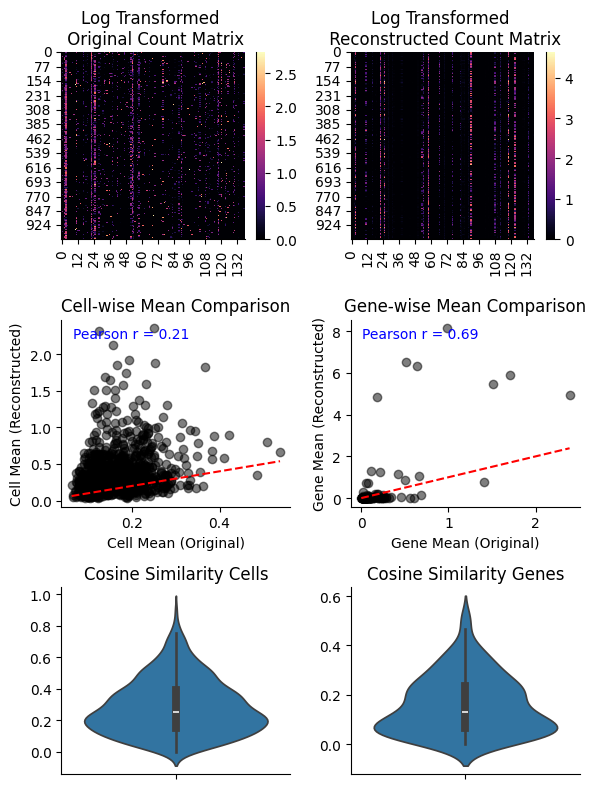

Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation and masked genes


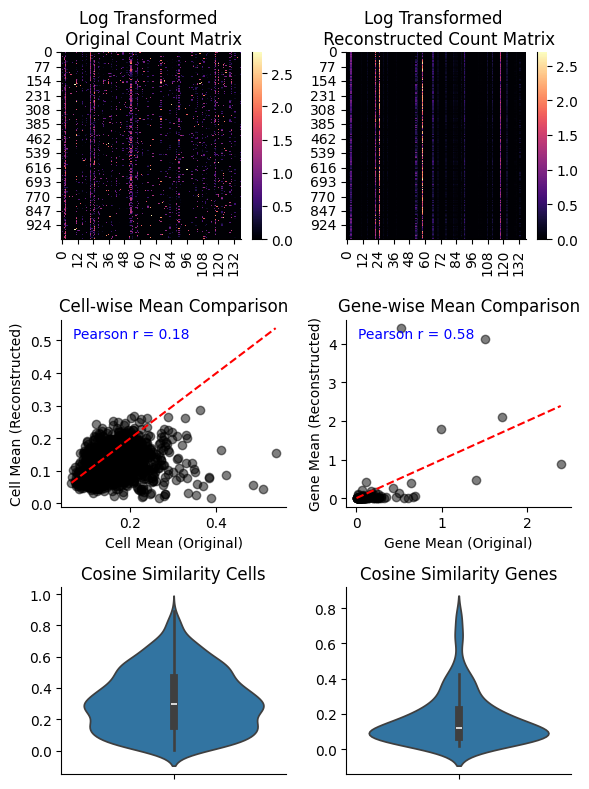

In [302]:
print(f"{n_components=}")
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using sklearn nmf and masked genes")
benchmark_reconstruction(
    res_masked_1["adata_query_array"],
    res_masked_1["V"],
)

print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation and masked genes")
benchmark_reconstruction(
    res_masked_2["adata_query_array"],
    res_masked_2["V"],
)

### Randomly Reconstructed Matrix by sampling featurewise

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_78257/875600890.py:30: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


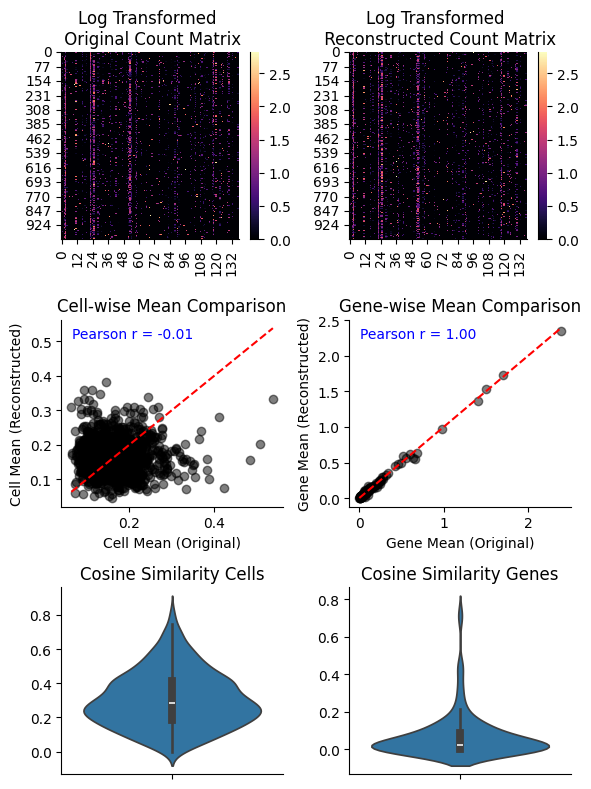

In [303]:
(lambda X:
 benchmark_reconstruction(
     X,
     np.apply_along_axis(lambda vec: np.random.choice(vec, size=len(vec), replace=True), axis=0, arr=X)
 ))(
    adata_sp[:, shared_genes].X.toarray()
    #adata_sc[:, shared_genes_mask_sc].X.toarray()
 )

### Initializing NMF #1 with rank genes of leiden clusters

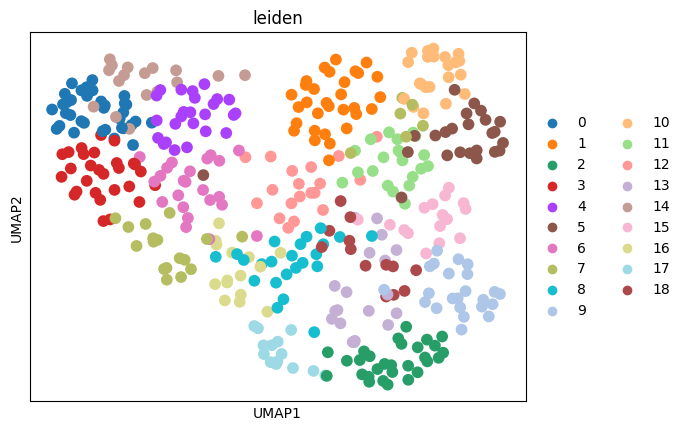

In [659]:
adata_sc_copy = adata_sc.copy()
sc.pp.normalize_total(adata_sc_copy)
sc.pp.log1p(adata_sc_copy)

sc.tl.pca(adata_sc_copy)
sc.pp.neighbors(adata_sc_copy)
sc.tl.leiden(adata_sc_copy, resolution=3)
sc.tl.umap(adata_sc_copy)
sc.pl.umap(adata_sc_copy,color='leiden')
sc.tl.rank_genes_groups(adata_sc_copy, 'leiden')

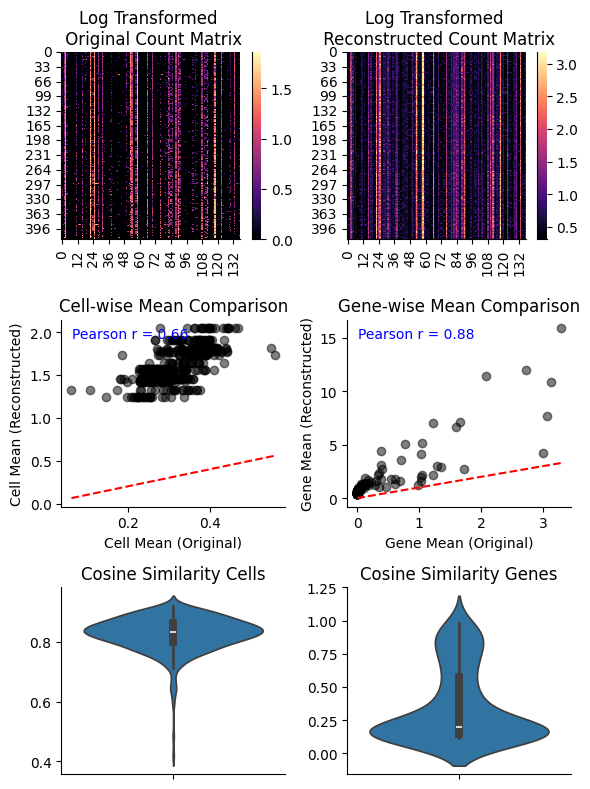

In [660]:
# W matrix constructed from the rank_genes_groups scores for the number of clusters.
H_leiden = (lambda arr: np.where(arr < 0, 0.1, arr))(
    pd.concat(
        [sc.get.rank_genes_groups_df(adata_sc_copy, index).set_index("names")["scores"] for index in list(adata_sc_copy.uns["rank_genes_groups"]["names"].dtype.names)], 
        axis=1
    ).reindex(adata_sc_copy.var.index).values.astype(adata_sc_copy.X.toarray().dtype).T
)
# H matrix constructed from cells belonging to a certain cluster (1 for belonging, 0.1 for not belonging)
W_leiden = pd.get_dummies(adata_sc_copy.obs["leiden"], dtype=adata_sc_copy.X.toarray().dtype).replace(0, 0.1).values
benchmark_reconstruction(adata_sc_copy[:, shared_genes_mask_sc].X.toarray(), W_leiden @ H_leiden[:, shared_genes_mask_sc])

100%|██████████| 200/200 [00:00<00:00, 7088.92it/s]


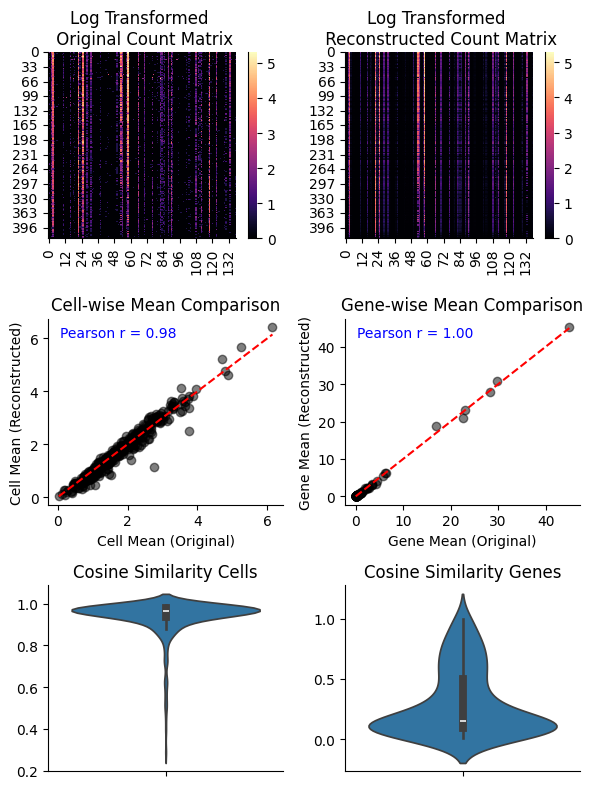

In [265]:
W_init_t, H_init_t, _ = non_negative_factorization_reimplementation(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), n_components=W_leiden.shape[1])
benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X.toarray(), W_init_t @ H_init_t)

100%|██████████| 200/200 [00:00<00:00, 10818.57it/s]


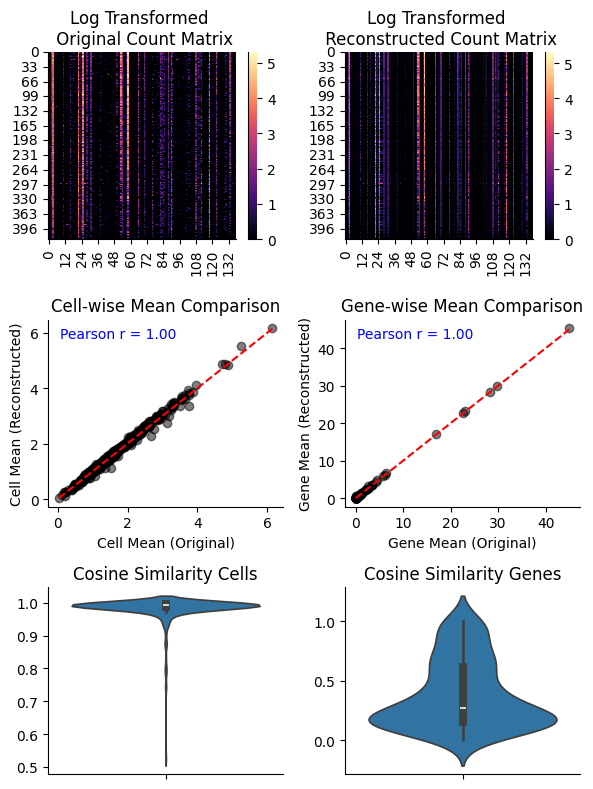

In [263]:
W_init, H_init, _ = non_negative_factorization_reimplementation(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), W=W_leiden, H=H_leiden[:, shared_genes_mask_sc])
benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X.toarray(), W_init @ H_init)

100%|██████████| 200/200 [00:00<00:00, 11276.53it/s]


H matrix fixed = True


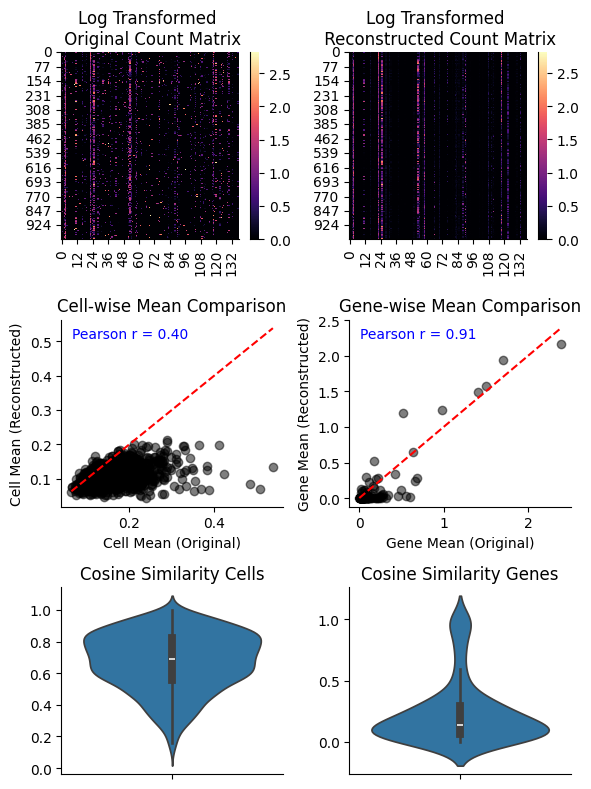

In [387]:
W, H, _ = non_negative_factorization_reimplementation(adata_sp[:, shared_genes].X.toarray().copy(), H=H_init, update_H=False)
print(f"H matrix fixed = {(H_init == H).all()}")
benchmark_reconstruction(adata_sp[:, shared_genes].X.toarray(), W @ H_init)

In [125]:
subidx, compidx = (lambda arr, n: (arr[n:], arr[:n]))(np.random.permutation(np.arange(0, len(shared_genes))), 10)
print(f"{len(subidx)=}, {len(compidx)=}")

len(subidx)=128, len(compidx)=10


In [377]:
W, H, _ = non_negative_factorization_reimplementation(adata_sp[:, shared_genes].X.toarray().copy()[:, subidx], H=H_init[:, subidx], update_H=False)
print(f"H matrix fixed = {(H_init[:, subidx] == H).all()}")

100%|██████████| 200/200 [00:00<00:00, 15312.71it/s]

H matrix fixed = True


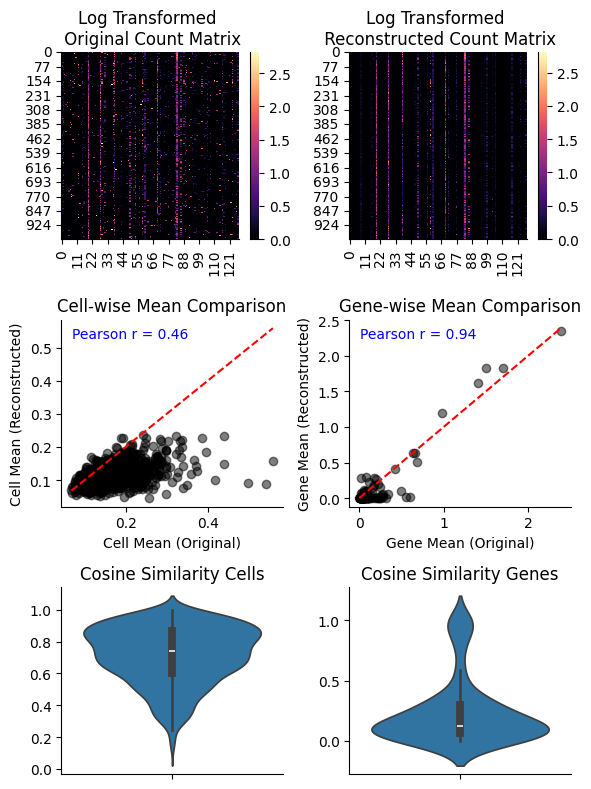

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_66838/1745384870.py:30: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


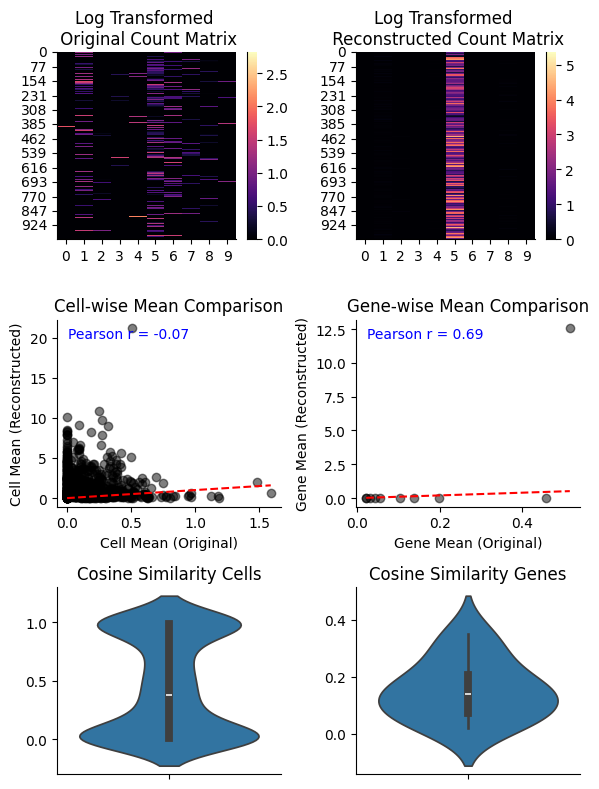

In [378]:
benchmark_reconstruction(adata_sp[:, shared_genes][:, subidx].X.toarray(), W @ H_init[:, subidx])
benchmark_reconstruction(adata_sp[:, shared_genes][:, compidx].X.toarray(), W @ H_init[:, compidx])

### Impact of Initialization for NMF run #1

In [508]:
[i for i in range(1, len(shared_genes)) if len(shared_genes) % i == 0]

[1, 2, 3, 6, 23, 46, 69]

In [664]:
n = 3
arr = np.arange(0, len(shared_genes))
arr = np.random.permutation(arr)
unshuffle = np.argsort(arr)
compidx = (lambda arr, n: np.hstack([arr.reshape(-1, n), np.array([arr[~np.isin(arr, sub)] for sub in arr.reshape(-1, n)])]))(
    arr, n
)

In [ ]:
def nmf_transfer_basic(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference.X.toarray(), n_components=n_components)
    # NMF run 2
    W, H, _ = nmf_func(adata_query[:, shared_genes].X.toarray(), H=H_init[:, shared_genes_mask_reference], update_H=False)
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "W": W,
        "H": H,
    }

In [783]:
def nmf_transfer_basic(
        adata_query: AnnData, 
        adata_reference: AnnData, 
        shared_genes_mask_reference: np.ndarray, 
        gene_filter_mask: np.ndarray | None = None,
        n_components: int | None = None, 
        nmf_func: callable = non_negative_factorization,
        W_init_reference: np.ndarray | None = None,
        H_init_reference: np.ndarray | None = None,
) -> tuple:

    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names

    if gene_filter_mask is None:
        gene_filter_mask = np.ones(len(shared_genes), dtype=bool)

    init_reference = "custom" if W_init_reference is not None or H_init_reference is not None else None

    W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*nmf_func(adata_query[:, shared_genes][:, gene_filter_mask].X.toarray(), H=H_init[:, gene_filter_mask], init="custom", update_H=False), W_init, H_init))(
        *nmf_func(adata_reference[:, shared_genes_mask_reference].X.toarray(), init=init_reference, W=W_init_reference.copy(order="C"), H=H_init_reference)
    )
    return W, H, W_init, H_init

In [787]:
W, H, W_init, H_init = nmf_transfer_basic(
    adata_sp, 
    adata_sc, 
    shared_genes_mask_reference=shared_genes_mask_sc,
    gene_filter_mask=np.isin(shared_genes, shared_genes[0]),
    W_init_reference=W_leiden, 
    H_init_reference=H_leiden[:, shared_genes_mask_sc], 
    nmf_func=non_negative_factorization
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [789]:
(lambda tuple: tuple[0] @ tuple[1])((W, H))

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.19899857e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.62133265e+00],
       [0.00000000e+00],
       [5.89512706e-01],
       [0.00000000e+00],
       [1.06955779e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.09017515e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.63050705e-01],
       [7.38861859e-01],
       [3.52522224e-01],
       [0.00000000e+00],
       [0.00000000e+00],


In [788]:
(W, H, W_init, H_init)

(array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.5778690e+02, 1.8486155e-06, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 array([[0.01218886],
        [0.03907834],
        [0.        ],
        [0.        ],
        [0.18364853],
        [0.12082093],
        [0.03299823],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.82443166],
        [0.14600731],
        [0.        ],


In [ ]:
(lambda gene_filter_mask: nmf_transfer_basic(
    adata_sp,
    adata_sc,
    shared_genes_mask_reference=shared_genes_mask_sc,
    gene_filter_mask=gene_filter_mask,
    W_init_reference=W_leiden,
    H_init_reference=H_leiden[:, shared_genes_mask_sc],
    nmf_func=non_negative_factorization
))

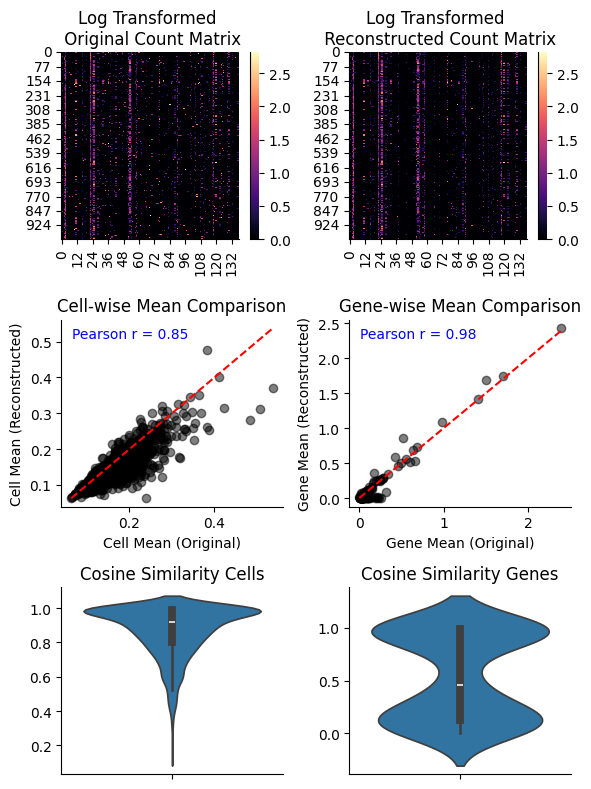

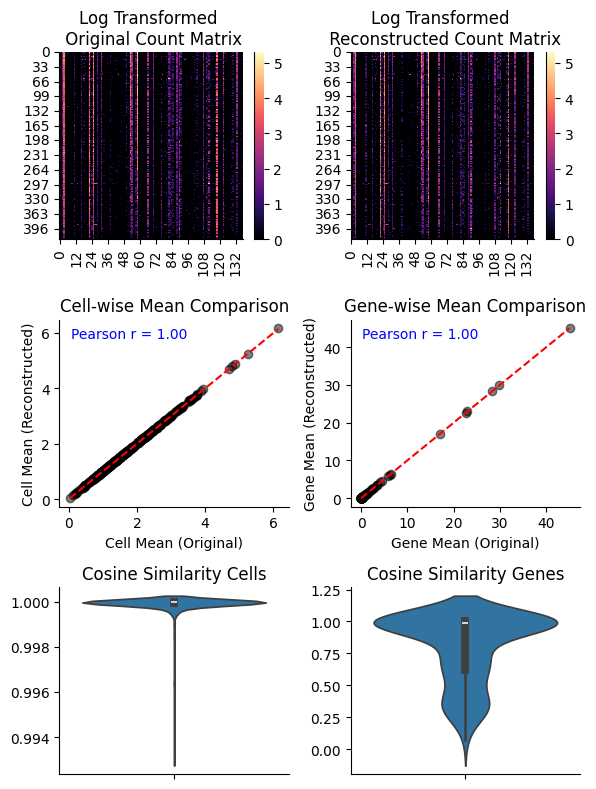

In [711]:
benchmark_reconstruction(adata_sp[:, shared_genes].X, W @ H)
benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X, W_init @ H_init)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

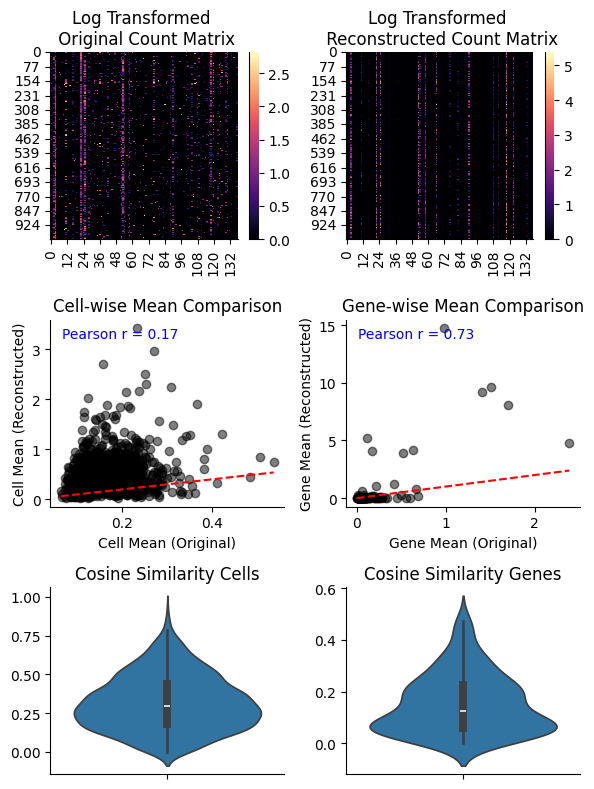

In [665]:
reconstruction = []
for genes in compidx:
    W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp[:, shared_genes][:, genes[n:]].X, H=H_init[:, genes[n:]], init="custom", update_H=False), W_init, H_init))(
        *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, n_components=W_leiden.shape[1])
    )
    reconstruction.append(W @ H_init[:, genes[:n]])

benchmark_reconstruction(
    adata_sp[:, shared_genes].X.toarray(),
    np.hstack(reconstruction)[:, unshuffle]
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

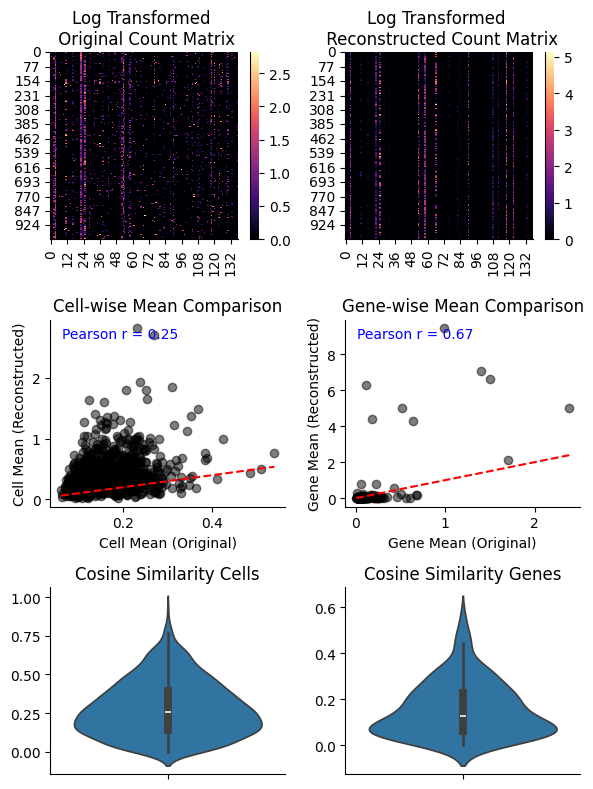

In [666]:
reconstruction = []
for genes in compidx:
    W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp[:, shared_genes][:, genes[n:]].X, H=H_init[:, genes[n:]], init="custom", update_H=False), W_init, H_init))(
        *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, n_components=W_leiden.shape[1])
    )
    reconstruction.append(W @ H_init[:, genes[:n]])

benchmark_reconstruction(
    adata_sp[:, shared_genes].X.toarray(),
    np.hstack(reconstruction)[:, unshuffle]
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

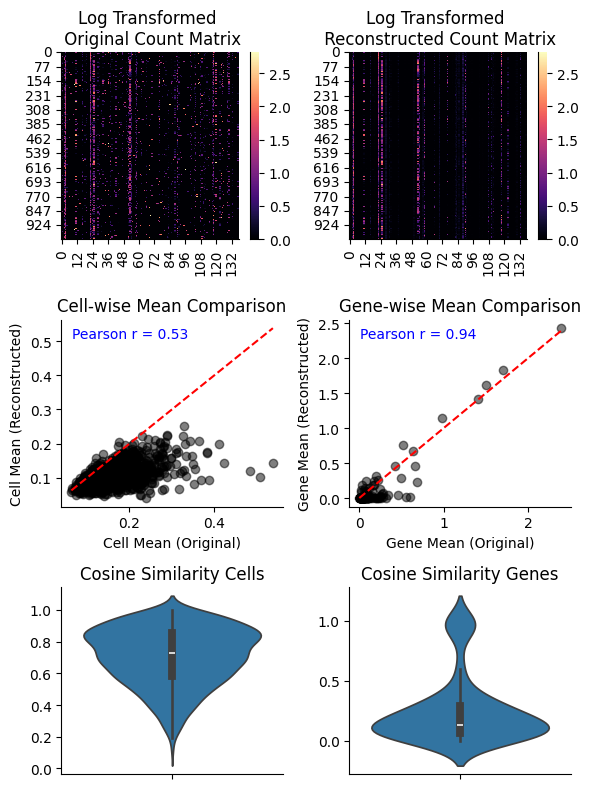

In [667]:
reconstruction = []
for genes in compidx:
    W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp[:, shared_genes].X, H=H_init, init="custom", update_H=False), W_init, H_init))(
        *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, W=W_leiden.copy(order='C'), H=H_leiden[:, shared_genes_mask_sc], init="custom")
    )
    reconstruction.append(W @ H_init[:, genes[:n]])

benchmark_reconstruction(
    adata_sp[:, shared_genes].X.toarray(),
    np.hstack(reconstruction)[:, unshuffle]
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

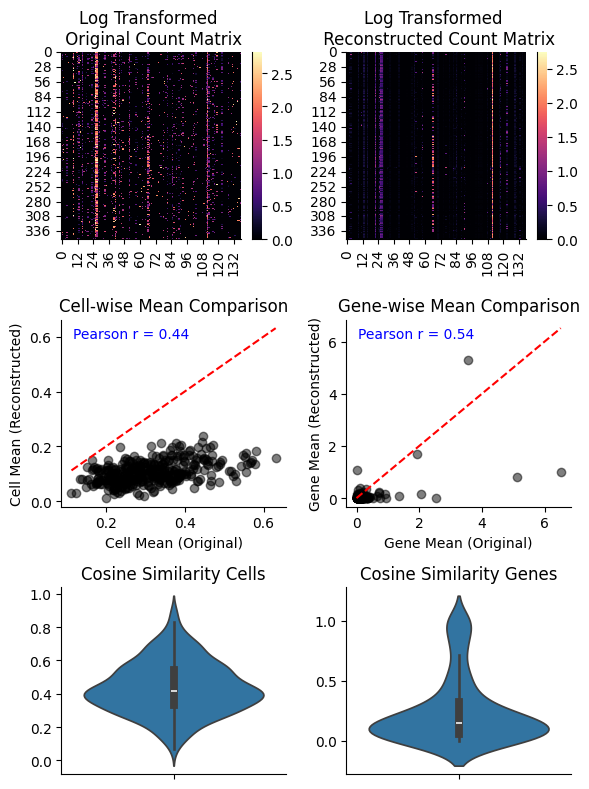

In [652]:
# Testing for different celltypes
adata_sp_ct = (lambda x: x[x.obs["nico_ct"] == "Macrophage"].copy())(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
reconstruction = []
for genes in compidx:
    W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp_ct[:, shared_genes].X, H=H_init, init="custom", update_H=False), W_init, H_init))(
        *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, W=W_leiden.copy(order='C'), H=H_leiden[:, shared_genes_mask_sc], init="custom")
    )
    reconstruction.append(W @ H_init[:, genes[:n]])

benchmark_reconstruction(
    adata_sp_ct[:, shared_genes].X.toarray(),
    np.hstack(reconstruction)[:, unshuffle]
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


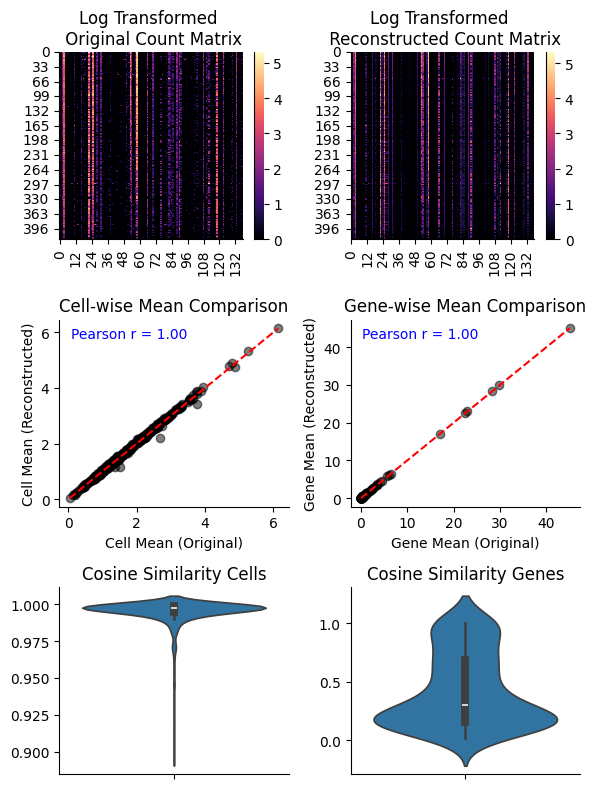

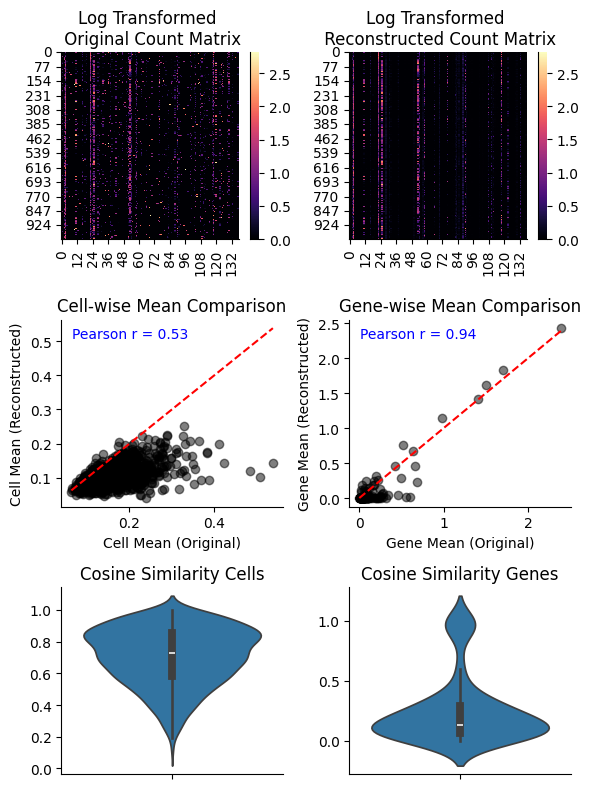

In [348]:
W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp[:, shared_genes].X, H=H_init, init="custom", update_H=False), W_init, H_init))(
    *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, W=W_leiden.copy(order='C'), H=H_leiden[:, shared_genes_mask_sc], init="custom")
)
benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X, W_init @ H_init)
benchmark_reconstruction(adata_sp[:, shared_genes].X, W @ H)

In [235]:

W_init, H_init, _ = non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, n_components=20)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [238]:

W_init, H_init, _ = non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, W=W_leiden.copy(order='C'), H=H_leiden[:, shared_genes_mask_sc], init="custom")

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [269]:
W_init_t, H_init_t, _ = non_negative_factorization_reimplementation(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), n_components=W_leiden.shape[1])

100%|██████████| 200/200 [00:00<00:00, 7393.97it/s]


In [275]:
W_leiden.shape[1]

14

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


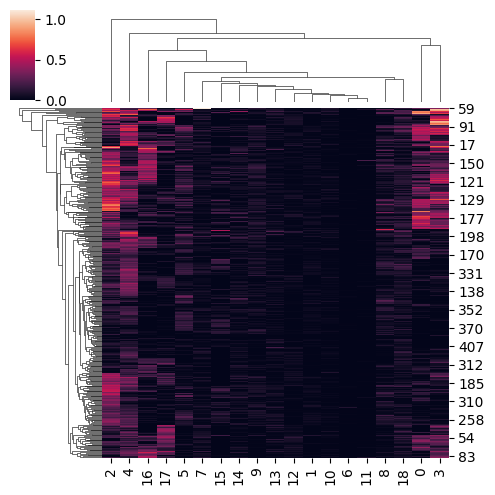

In [350]:
(lambda W_init, H_init, _: sns.clustermap(np.log1p(W_init), figsize=(5,5,)))(
    *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), n_components=W_leiden.shape[1])
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


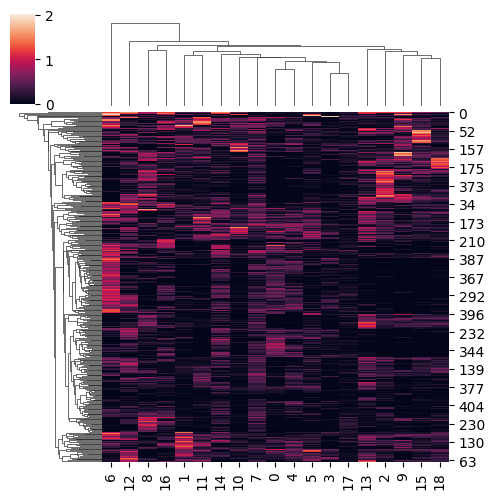

In [351]:
(lambda W_init, H_init, _: sns.clustermap(np.log1p(W_init), figsize=(5,5,)))(
    *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, W=W_leiden.copy(order='C'), H=H_leiden[:, shared_genes_mask_sc], init="custom", solver="mu")
)

In [136]:
W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp[:, shared_genes][:, subidx].X, H=H_init[:, subidx], init="custom", update_H=False), W_init, H_init))(
    *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, n_components=10)
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [134]:
W, H, _, W_init, H_init = (lambda W_init, H_init, _: (*non_negative_factorization(adata_sp[:, shared_genes][:, subidx].X, H=H_init[:, subidx], init="custom", update_H=False), W_init, H_init))(
    *non_negative_factorization(adata_sc[:, shared_genes_mask_sc].X, W=W_leiden.copy(order='C'), H=H_leiden[:, shared_genes_mask_sc], init="custom")
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [67]:
len(shared_genes) % 2

0

In [94]:
[i for i in range(1, len(shared_genes)) if len(shared_genes) % i == 0]

[1, 2, 3, 6, 23, 46, 69]

In [98]:
np.random.permutation(np.arange(0, len(shared_genes))).reshape((-1,3))

array([[109,  19, 131],
       [ 94,  72,  79],
       [ 16,  93, 111],
       [ 92,  26,   8],
       [100,  55,  15],
       [119,  77,  75],
       [129,  32,   7],
       [136,  53,  89],
       [ 62,  86,  44],
       [124, 135,  80],
       [ 69,  21,  88],
       [ 42,  18,  73],
       [ 98,  63,  67],
       [130,  81, 108],
       [ 59, 105,  71],
       [104,  57,  35],
       [114,  31,  95],
       [ 65, 123,  51],
       [ 12,  78,  22],
       [ 17, 112,  36],
       [118,  49,  83],
       [ 11,  54,   1],
       [ 66,  56,  99],
       [ 50,  10,  97],
       [ 60,  84, 106],
       [113, 103, 127],
       [ 82,  25,  96],
       [ 64, 121,  76],
       [110,  24,  27],
       [ 68,  28, 134],
       [ 85, 126,  90],
       [ 70, 102, 132],
       [ 43,  39,  14],
       [120,  38,  20],
       [ 58,  52,  13],
       [ 40, 128,  23],
       [ 91,   4,  74],
       [  5,  29,  48],
       [  0,   3, 101],
       [ 34,  30, 122],
       [  6,  45, 107],
       [ 61, 116

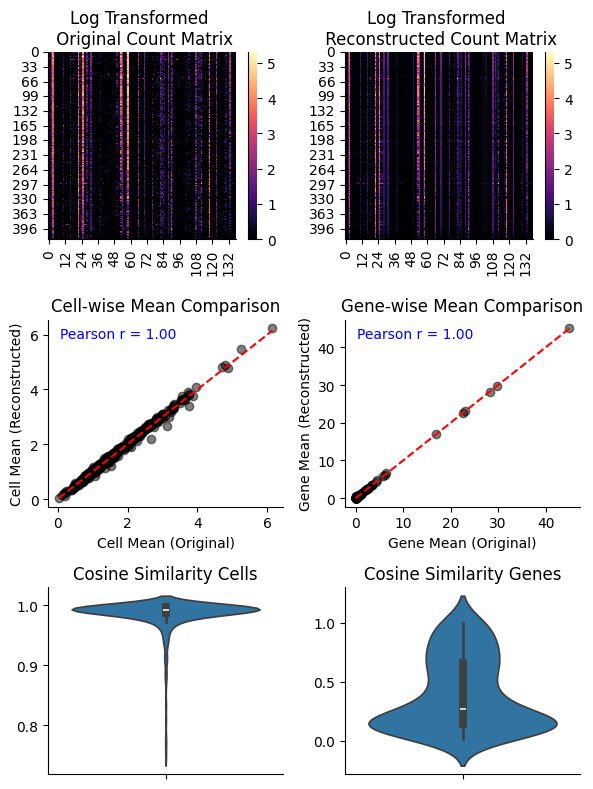

In [138]:
sparse_to_numpy(benchmark_reconstruction)(adata_sc[:, shared_genes_mask_sc].X, (W_init @ H_init))

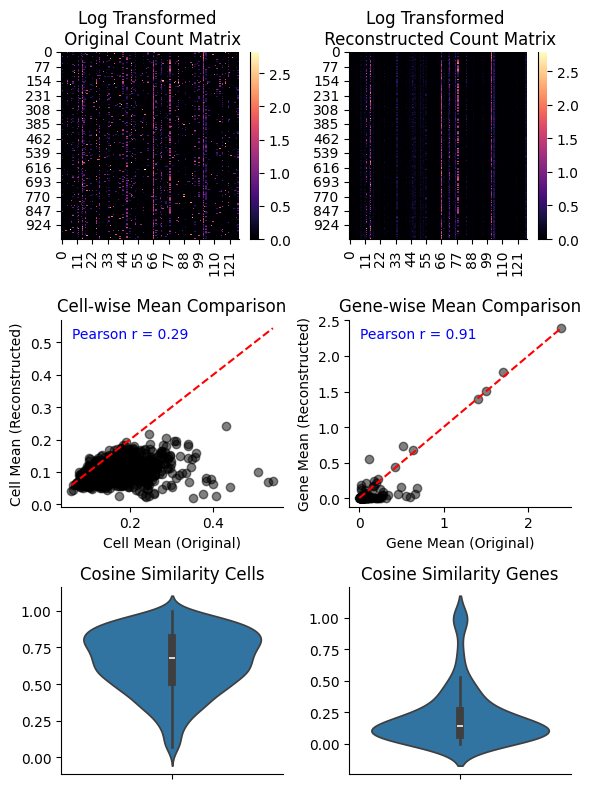

In [139]:

sparse_to_numpy(benchmark_reconstruction)(adata_sp[:, shared_genes][:, subidx].X, (W @ H))

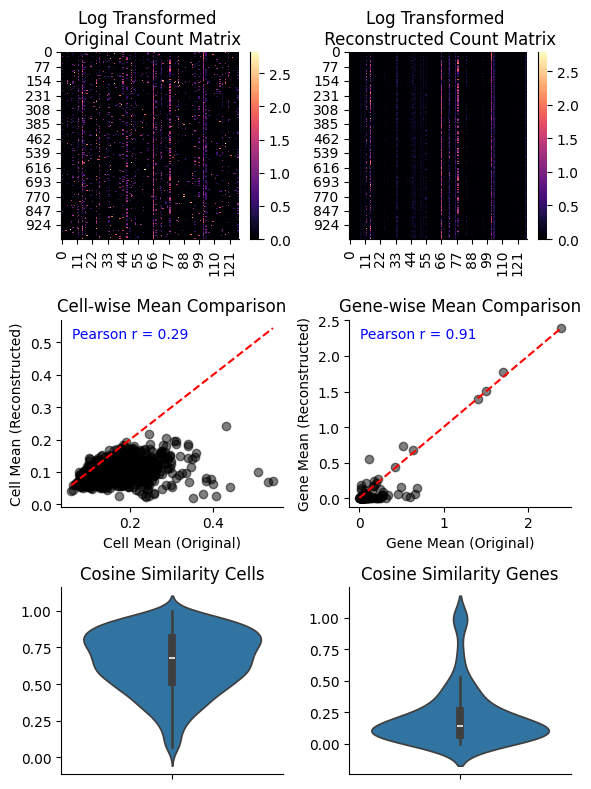

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_78257/1745384870.py:30: RuntimeWarning: invalid value encountered in divide
  return dot_products / (norms_A * norms_B)


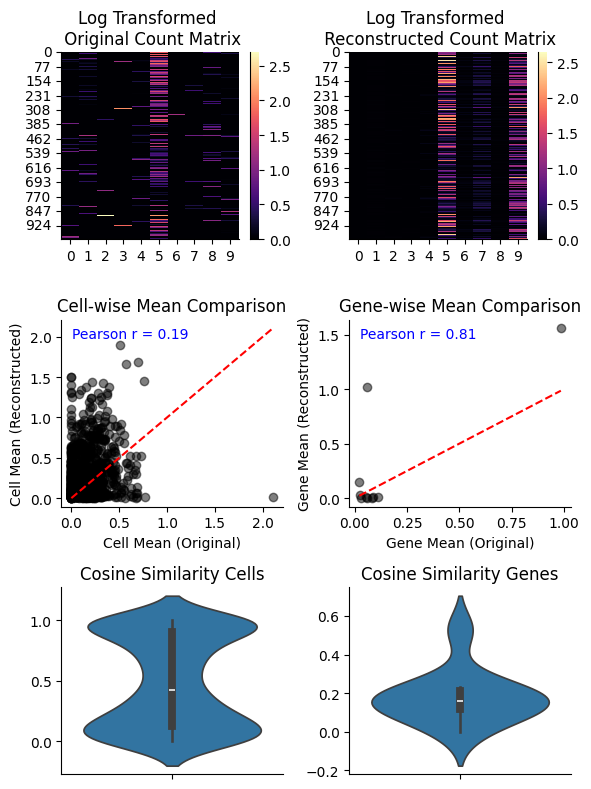

In [137]:
sparse_to_numpy(benchmark_reconstruction)(adata_sp[:, shared_genes][:, subidx].X, (W @ H_init)[:, subidx])
sparse_to_numpy(benchmark_reconstruction)(adata_sp[:, shared_genes][:, compidx].X, (W @ H_init)[:, compidx])

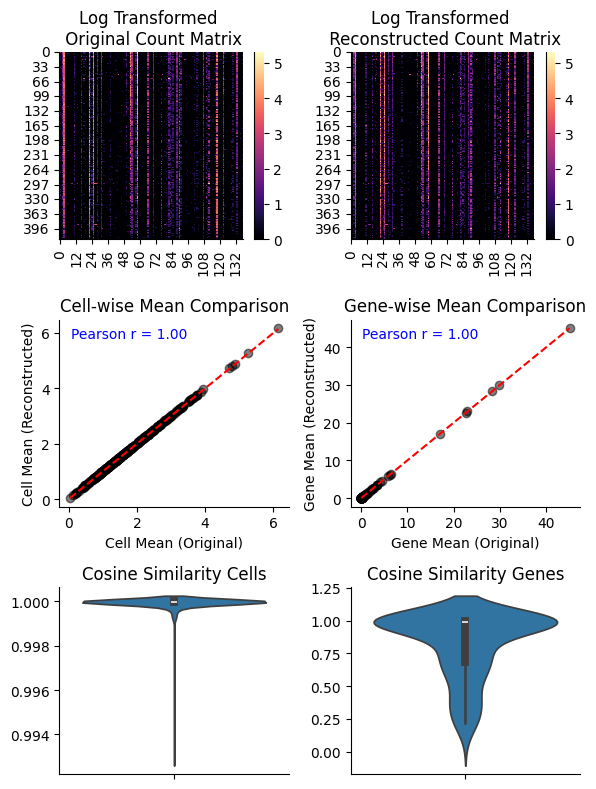

In [38]:
sparse_to_numpy(benchmark_reconstruction)(adata_sc[:, shared_genes_mask_sc].X, W @ H)

In [ ]:
sparse_to_numpy(lambda X: benchmark_reconstruction(X, ))

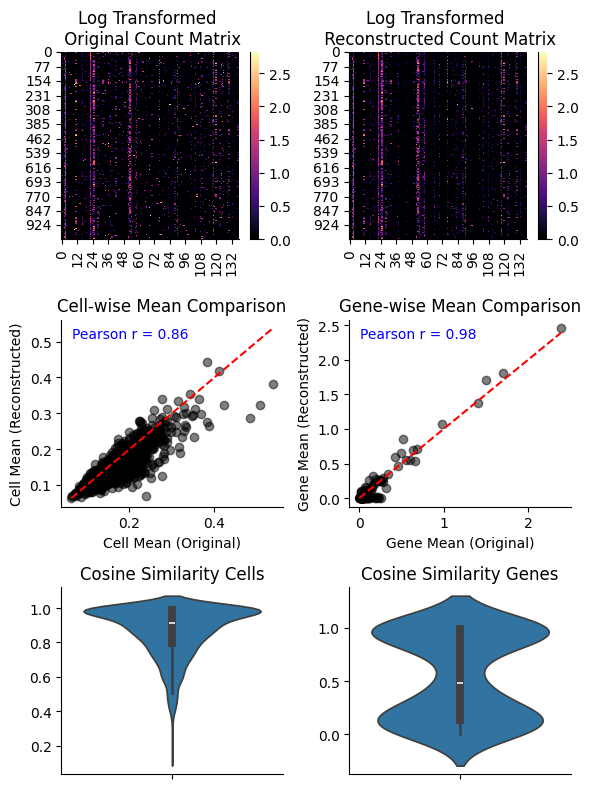

In [37]:
sparse_to_numpy(benchmark_reconstruction)(adata_sp[:, shared_genes].X, W2 @ H)

In [492]:
cell_pearson = []
gene_pearson = []
n_components_range = np.linspace(3, 20, 5, dtype=int)
for n_components in n_components_range:
    X = adata_sp[:, shared_genes].X.toarray().copy()
    W_init, H_init, _ = non_negative_factorization_reimplementation(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), W=W_leiden, H=H_leiden[:, shared_genes_mask_sc])
    W, H, _ = non_negative_factorization_reimplementation(X, H=H_init, update_H=False)
    V = W @ H
    cell_pearson.append(pearsonr(X.mean(axis=1), V.mean(axis=1))[0])
    gene_pearson.append(pearsonr(X.mean(axis=0), V.mean(axis=0))[0])

100%|██████████| 200/200 [00:00<00:00, 16806.80it/s]


In [575]:
subidx, compidx = (lambda arr, n: (arr[n:], arr[:n]))(np.random.permutation(np.arange(0, len(shared_genes))), 10)
cell_pearson = []
gene_pearson = []
cell_pearson_unknown = []
gene_pearson_unknown = []
n_components_range = np.linspace(3, 20, 5, dtype=int)
for n_components in n_components_range:
    X = adata_sp[:, shared_genes].X.toarray().copy()
    W_init, H_init, _ = non_negative_factorization_reimplementation(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), n_components=n_components)
    W, H, _ = non_negative_factorization_reimplementation(X[:, subidx], H=H_init[:, subidx], update_H=False)
    V = W @ H_init
    cell_pearson.append(pearsonr(X[:, subidx].mean(axis=1), V[:, subidx].mean(axis=1))[0])
    gene_pearson.append(pearsonr(X[:, subidx].mean(axis=0), V[:, subidx].mean(axis=0))[0])
    cell_pearson_unknown.append(pearsonr(X[:, compidx].mean(axis=1), V[:, compidx].mean(axis=1))[0])
    gene_pearson_unknown.append(pearsonr(X[:, compidx].mean(axis=0), V[:, compidx].mean(axis=0))[0])


plt.figure(figsize=(8, 6))

plt.scatter(n_components_range, cell_pearson, label="Pearson r Cell", color='blue')
plt.plot(n_components_range, cell_pearson, linestyle='-', color='blue')

plt.scatter(n_components_range, gene_pearson, label="Pearson r Gene", color='red')
plt.plot(n_components_range, gene_pearson, linestyle='-', color='red')

plt.scatter(n_components_range, cell_pearson_unknown, label="Pearson r Cell unknown", color='blue')
plt.plot(n_components_range, cell_pearson_unknown, linestyle='--', color='blue')

plt.scatter(n_components_range, gene_pearson_unknown, label="Pearson r Gene unknown", color='red')
plt.plot(n_components_range, gene_pearson_unknown, linestyle='--', color='red')

plt.xlabel("Number of Components")
plt.ylim(-1, 1)
plt.ylabel("Pearson Correlation")
plt.title("Pearson Correlation vs. Number of Components")
plt.legend()  

plt.show()

100%|██████████| 200/200 [00:00<00:00, 10525.10it/s]


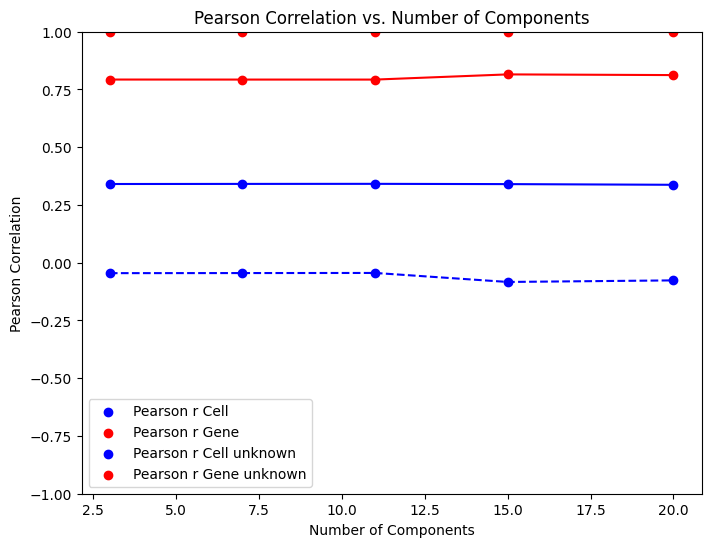

In [576]:

plt.figure(figsize=(8, 6))

plt.scatter(n_components_range, cell_pearson, label="Pearson r Cell", color='blue')
plt.plot(n_components_range, cell_pearson, linestyle='-', color='blue')

plt.scatter(n_components_range, gene_pearson, label="Pearson r Gene", color='red')
plt.plot(n_components_range, gene_pearson, linestyle='-', color='red')

plt.scatter(n_components_range, cell_pearson_unknown, label="Pearson r Cell unknown", color='blue')
plt.plot(n_components_range, cell_pearson_unknown, linestyle='--', color='blue')

plt.scatter(n_components_range, gene_pearson_unknown, label="Pearson r Gene unknown", color='red')
plt.plot(n_components_range, gene_pearson_unknown, linestyle='--', color='red')

plt.xlabel("Number of Components")
plt.ylim(-1, 1)
plt.ylabel("Pearson Correlation")
plt.title("Pearson Correlation vs. Number of Components")
plt.legend()  

plt.show()

In [587]:
num_repeats = 50  

n_components_range = np.linspace(3, 20, 5, dtype=int)

cell_pearson_data = {n: [] for n in n_components_range}
gene_pearson_data = {n: [] for n in n_components_range}
cell_pearson_unknown_data = {n: [] for n in n_components_range}
gene_pearson_unknown_data = {n: [] for n in n_components_range}

for _ in range(num_repeats):
    subidx, compidx = (lambda arr, n: (arr[n:], arr[:n]))(np.random.permutation(np.arange(0, len(shared_genes))), 80)

    for n_components in n_components_range:
        X = adata_sp[:, shared_genes].X.toarray().copy()
        
        W_init, H_init, _ = non_negative_factorization_reimplementation(
            adata_sc[:, shared_genes_mask_sc].X.toarray().copy(),
            n_components=n_components
        )

        W, H, _ = non_negative_factorization_reimplementation(
            X[:, subidx], H=H_init[:, subidx], update_H=False
        )

        V = W @ H_init

        cell_pearson_data[n_components].append(pearsonr(X[:, subidx].mean(axis=1), V[:, subidx].mean(axis=1))[0])
        gene_pearson_data[n_components].append(pearsonr(X[:, subidx].mean(axis=0), V[:, subidx].mean(axis=0))[0])
        cell_pearson_unknown_data[n_components].append(pearsonr(X[:, compidx].mean(axis=1), V[:, compidx].mean(axis=1))[0])
        gene_pearson_unknown_data[n_components].append(pearsonr(X[:, compidx].mean(axis=0), V[:, compidx].mean(axis=0))[0])


100%|██████████| 200/200 [00:00<00:00, 16180.17it/s]


/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_66838/3382774458.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_66838/3382774458.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_66838/3382774458.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_66838/3382774458.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9

{'whiskers': [<matplotlib.lines.Line2D at 0x148bdc640>,
 'caps': [<matplotlib.lines.Line2D at 0x148bdcc40>,
 'boxes': [<matplotlib.patches.PathPatch at 0x148beafb0>,
 'medians': [<matplotlib.lines.Line2D at 0x148bdd240>,
 'fliers': [<matplotlib.lines.Line2D at 0x148bdd540>,
 'means': []}

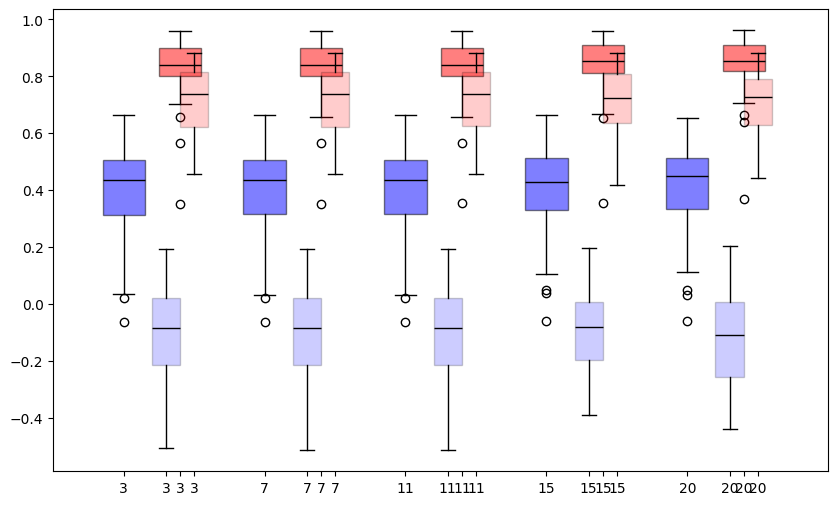

In [588]:
x_positions = np.arange(len(n_components_range)) 
plt.figure(figsize=(10, 6))

labels = [f"{n}" for n in n_components_range]

plt.boxplot(
    [cell_pearson_data[n] for n in n_components_range],
    positions=np.arange(len(n_components_range)) - 0.2,  
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor='blue', alpha=0.5),
    medianprops=dict(color='black'),
    labels=labels
)

plt.boxplot(
    [gene_pearson_data[n] for n in n_components_range],
    positions=np.arange(len(n_components_range)) + 0.2,  
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor='red', alpha=0.5),
    medianprops=dict(color='black'),
    labels=labels
)
plt.boxplot(
    [cell_pearson_unknown_data[n] for n in n_components_range],
    positions=x_positions + 0.1,  
    widths=0.2,
    patch_artist=True,
    boxprops=dict(facecolor='blue', alpha=0.2), 
    medianprops=dict(color='black'),
    labels=labels
)

plt.boxplot(
    [gene_pearson_unknown_data[n] for n in n_components_range],
    positions=x_positions + 0.3,  
    widths=0.2,
    patch_artist=True,
    boxprops=dict(facecolor='red', alpha=0.2),  
    medianprops=dict(color='black'),
    labels=labels
)